In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt

In [3]:
from CENSAr.datasources import (
    personas_radios_prov,
    tipoviv_radios_prov,
    radios_prov,
    radios_eph_censo_2010,
    persproy_depto_2025,
)
import h3pandas

In [4]:
from CENSAr.modeling_tools import simulate_total_var, simulate_cat_var

In [5]:
# GEOMETRIAS
envolvente = radios_eph_censo_2010(aglo_idx="08")
chaco_2001 = radios_prov(year=2001, prov="chaco", mask=envolvente)
chaco_2010 = radios_prov(year=2010, prov="chaco", mask=envolvente)

[15:54:03] INFO     https://storage.googleapis.com/python_mdg/censar_carto/radios_eph_json.zip   ]8;id=728326;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=581053;file:///workspace/CENSAr/datasources.py#103\103]8;;\

In [8]:
# TABLAS REDATAM - HOGARES/VIVIENDAS
tipo_2001 = tipoviv_radios_prov(
    year=2001,
    prov="chaco",
    var_types={"link": "object"},
)
tipo_2001_geo = chaco_2001.set_index("link").join(tipo_2001.set_index("link"))
tipo_2010 = tipoviv_radios_prov(
    year=2010,
    prov="chaco",
    var_types={"link": "object"},
)
tipo_2010_geo = chaco_2010.set_index("link").join(tipo_2010.set_index("link"))

[15:54:48] INFO     loading                                                                      ]8;id=291161;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=310746;file:///workspace/CENSAr/datasources.py#112\112]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    chaco_2001.csv`                                                                                

[15:54:49] INFO     loading                                                                      ]8;id=121488;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=210007;file:///workspace/CENSAr/datasources.py#112\112]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    chaco_2010.csv`                                                                                

In [9]:
# TABLAS REDATAM - PERSONAS
pers_2001 = personas_radios_prov(year=2001, prov="chaco", var_types={"link": "object"})
pers_2001_geo = chaco_2001.set_index("link").join(pers_2001.set_index("link"))
pers_2010 = personas_radios_prov(year=2010, prov="chaco", var_types={"link": "object"})
pers_2010_geo = chaco_2010.set_index("link").join(pers_2010.set_index("link"))

[15:54:51] INFO     loading                                                                      ]8;id=910929;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=636974;file:///workspace/CENSAr/datasources.py#134\134]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/personas_radios_chaco                   
                    _2001.csv`                                                                                     

           INFO     loading                                                                      ]8;id=21517;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=976626;file:///workspace/CENSAr/datasources.py#134\134]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/personas_radios_chaco                   
                    _2010.csv`                                                                                     

In [10]:
# Tabla de proyecciones de poblacion por departamento
proy = persproy_depto_2025(prov="chaco")

[15:54:52] INFO     loading,                                                                     ]8;id=304173;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=546492;file:///workspace/CENSAr/datasources.py#168\168]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/persproyect_depto_cha                   
                    co.csv`                                                                                        

In [11]:
# Total viviendas 2020
tipo_2010_geo["total_2020"] = simulate_total_var(
    gdf_pers_01=pers_2001_geo,
    gdf_var_01=tipo_2001_geo,
    gdf_pers_10=pers_2010_geo,
    gdf_var_10=tipo_2010_geo,
    proy_df=proy,
    namedept="San Fernando",
    base_year="2010",
    forecast_year="2020",
    catname="total",
)

The total number of projected households/residential units is 132131


<Axes: >

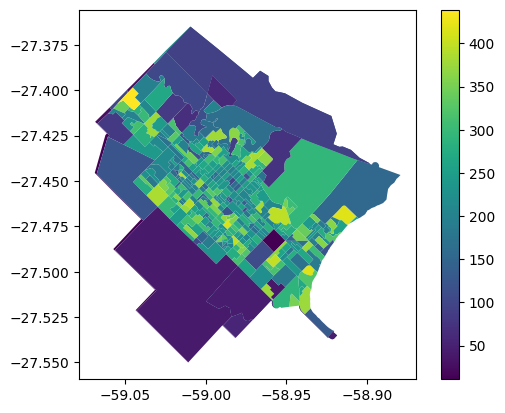

In [12]:
tipo_2001_geo.plot(column="total", legend=True)

/usr/local/lib/python3.10/dist-packages/h3pandas/h3pandas.py:751: UserWarning: 29 rows did not generate a H3 cell.Consider using a finer resolution.
  warnings.warn(


<Axes: >

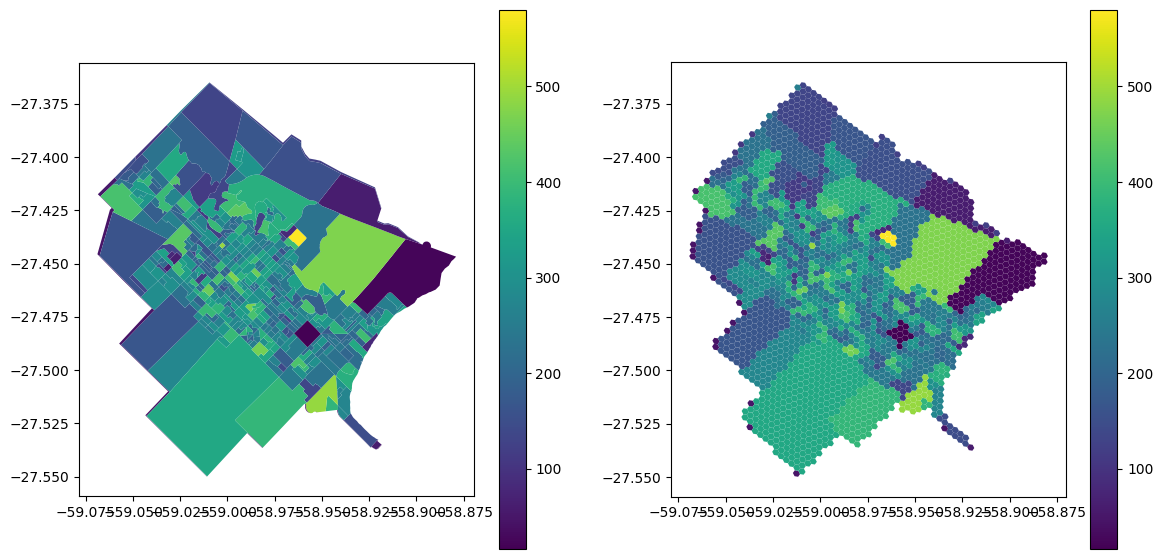

In [20]:
from CENSAr.clustering.h3_geo import geopandas_to_h3

fig, subplots = plt.subplots(1, 2, figsize=(14, 7))


tipo_2010_h3 = geopandas_to_h3(tipo_2010_geo, 9)

tipo_2010_geo.plot(column="total", legend=True, ax=subplots[0])
tipo_2010_h3.plot(column="total", legend=True, ax=subplots[1])

In [21]:
from esda.moran import Moran, Moran_Local
from libpysal import weights  # Spatial weights

In [23]:
w_queen = weights.Queen.from_dataframe(tipo_2010_h3)
w_knn = weights.KNN.from_dataframe(tipo_2010_h3, k=5)

In [24]:
moran = Moran(tipo_2010_h3["total"], w_queen)
lisa = Moran_Local(tipo_2010_h3["total"], w_queen)

In [25]:
is_significant = lisa.p_sim < 0.05
is_significant * lisa.q

array([0, 0, 0, ..., 0, 0, 0])

<Axes: ylabel='Density'>

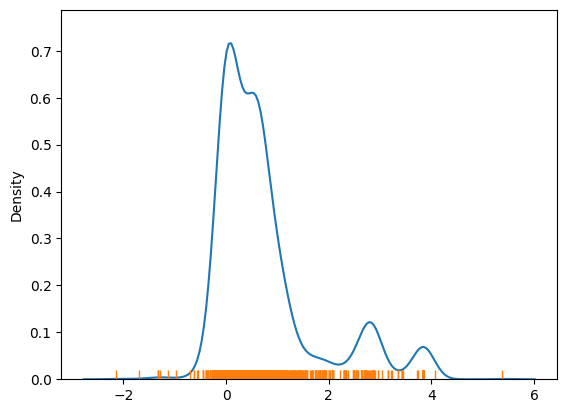

In [26]:
import seaborn as sns

sns.kdeplot(lisa.Is)
sns.rugplot(lisa.Is)

In [28]:
from splot import esda as esdaplot

(<Figure size 1400x700 with 3 Axes>, <Axes: >)

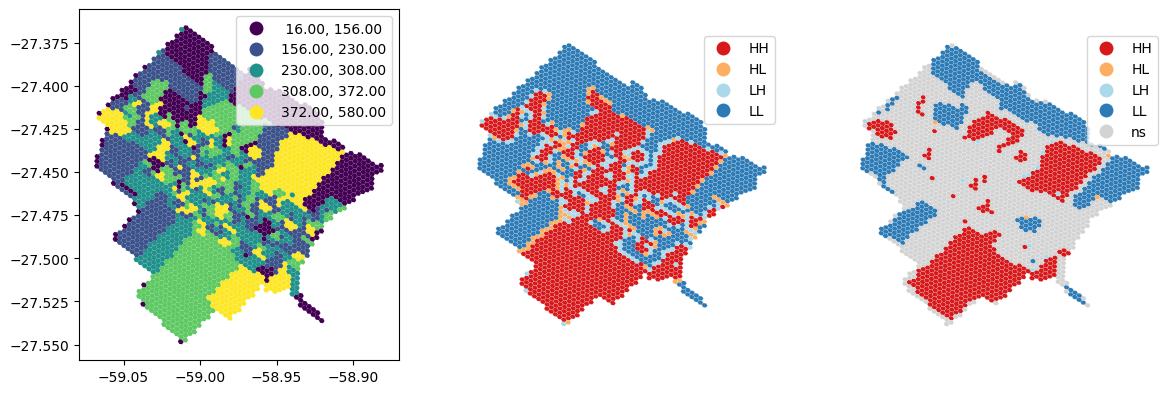

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))

tipo_2010_h3.plot(column="total", legend=True, ax=ax[0], scheme="quantiles")
esdaplot.lisa_cluster(lisa, tipo_2010_h3, p=1, ax=ax[1])
esdaplot.lisa_cluster(lisa, tipo_2010_h3, p=0.05, ax=ax[2])

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>)

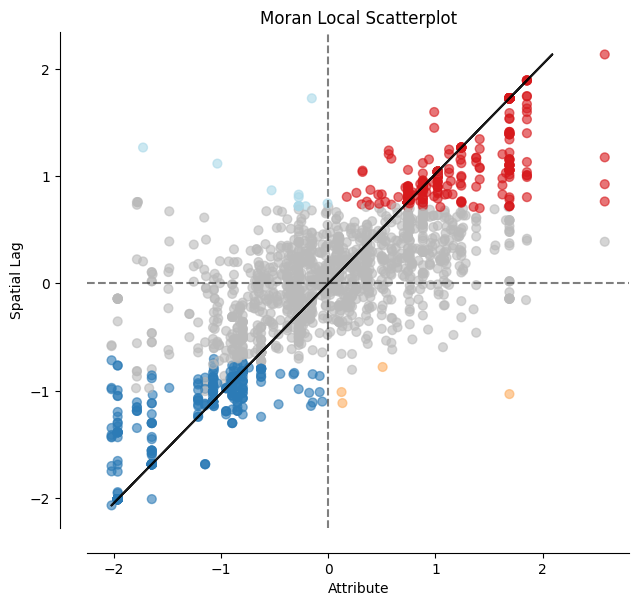

In [35]:
esdaplot.moran_scatterplot(lisa, p=0.05)